This file operates on the hypertension_full.csv data which had been created by the file DSI_project_v2.ipynb using the dataset present in healthcare-dataset-stroke-data.csv

For further details on how hypertension_full.csv was created, and the data it contains, please read the documentation in DSI_project_v2.ipynb

In [425]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
#from plotnine import ggplot, aes, geom_boxplot, labs, guides
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
import statsmodels.api as sm

In [426]:
df = pd.read_csv("hypertension_full.csv")
print (df.dtypes)

gender                     object
age                       float64
hypertension                int64
heart_disease               int64
ever_married               object
work_type                  object
Residence_type             object
avg_glucose_level         float64
bmi                       float64
smoking_status             object
stroke                      int64
gender_encoded              int64
ever_married_encoded        int64
work_type_encoded           int64
Residence_type_encoded      int64
smoking_status_encoded      int64
Age_temp                    int64
avg_glucose_level_temp      int64
dtype: object


Note that gender and smoking_status are showing up as object variables even though they were category variables when this dataframe was written to hypertension_full.csv by DSI_project_v2.ipynb. This is a known issue 

in pandas. 

In [427]:
print (df.shape)

(4242, 18)


In [428]:
# Convert categorical columns back to "category"
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_cols:
    df[col] = df[col].astype('category')

print(df.dtypes)

gender                    category
age                        float64
hypertension                 int64
heart_disease                int64
ever_married              category
work_type                 category
Residence_type            category
avg_glucose_level          float64
bmi                        float64
smoking_status            category
stroke                       int64
gender_encoded               int64
ever_married_encoded         int64
work_type_encoded            int64
Residence_type_encoded       int64
smoking_status_encoded       int64
Age_temp                     int64
avg_glucose_level_temp       int64
dtype: object


Before we proceed further let us fix one issue that was noted with the outout of DSI_project_v2.ipynb. It was noted that for hypertension only (that is, not for stroke or heart_disease) there exist

observations in the Never worked sub-category of Work type which should be dropped from the hypertension dataframe because none of these have a hypertension = 1 observation and hence no model we  come up with would

be able to classify such observations (of type Work type = Never worked) from some new dataset correctly in the event that the new data has one or more hypertension = 1 observations. Let us confirm this, 

and if so we will drop all such observations from the dataframe.


In [429]:
work_type_counts = df['work_type'].value_counts()
print (work_type_counts)

work_type
Private          2787
Self-employed     798
Govt_job          648
Never_worked        9
Name: count, dtype: int64


Let us now check if any of the 9 work_type = Never_worked observations have hypertension = 1

In [430]:
df_never_worked = df[(df['work_type'] == 'Never_worked')]
print (df_never_worked)

      gender   age  hypertension  heart_disease ever_married     work_type  \
789   Female  19.0             0              0           No  Never_worked   
849     Male  17.0             0              0           No  Never_worked   
1257    Male  17.0             0              0           No  Never_worked   
2286  Female  17.0             0              0           No  Never_worked   
2449  Female  18.0             0              0           No  Never_worked   
2910    Male  17.0             0              0           No  Never_worked   
3468  Female  18.0             0              0           No  Never_worked   
3829  Female  17.0             0              0           No  Never_worked   
3971  Female  18.0             0              0           No  Never_worked   

     Residence_type  avg_glucose_level   bmi smoking_status  stroke  \
789           Urban              86.96  25.8   never smoked       0   
849           Urban             113.25  23.4   never smoked       0   
1257  

At this point let us drop all nine observations with Work_type = Never_worked

In [431]:
df = df[df['work_type'] != 'Never_worked']

In [432]:
#Creating the composite variable
df['heart_stroke_risk'] = (df['heart_disease'] | df['stroke']).astype(int)

# Verify the result
#print(df[['heart_disease', 'stroke', 'heart_stroke_risk']].head(10))
#print(df[['heart_disease', 'stroke', 'heart_stroke_risk']].tail(10))

In [433]:
print (df.dtypes)


gender                    category
age                        float64
hypertension                 int64
heart_disease                int64
ever_married              category
work_type                 category
Residence_type            category
avg_glucose_level          float64
bmi                        float64
smoking_status            category
stroke                       int64
gender_encoded               int64
ever_married_encoded         int64
work_type_encoded            int64
Residence_type_encoded       int64
smoking_status_encoded       int64
Age_temp                     int64
avg_glucose_level_temp       int64
heart_stroke_risk            int64
dtype: object


In [434]:
# Select all category variables in this dataset and obtain the counts of each levels of those variables.
category_columns = df.select_dtypes(include='category').columns

for col in category_columns:
    print(f"\nCount of each level in '{col}':")
    counts = df[col].value_counts()
    for category, count in counts.items():
        print(f"{category}: {count}")


Count of each level in 'gender':
Female: 2554
Male: 1679

Count of each level in 'ever_married':
Yes: 3308
No: 925

Count of each level in 'work_type':
Private: 2787
Self-employed: 798
Govt_job: 648
Never_worked: 0

Count of each level in 'Residence_type':
Urban: 2154
Rural: 2079

Count of each level in 'smoking_status':
never smoked: 1739
Unknown: 871
formerly smoked: 850
smokes: 773


Let us drop the Never_worked category from the work_type variable

In [435]:
df['work_type'] = df['work_type'].cat.remove_categories('Never_worked')
print (df['work_type'].cat.categories)

Index(['Govt_job', 'Private', 'Self-employed'], dtype='object')


In [436]:
#This function does a Chi square test of independence on two nominal variables. It returns the Chi Square test statistic, p-value, degrees of freedom, and expected frequencies
def chi_square(dataframe, var1, var2):
    try:
        # Create the contingency table
        contingency_table = pd.crosstab(dataframe[var1], dataframe[var2])

        # Do the chi-square test
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        #Calculate Cramer's V
        n = contingency_table.sum().sum()  # Total number of observations
        k = contingency_table.shape[1]     # Number of columns
        r = contingency_table.shape[0]     # Number of rows
        cramers_v = np.sqrt(chi2 / (n * min(k-1, r-1)))


        
        return chi2, p, dof, expected, cramers_v

    except:
        print(f"Error performing chi-square test")



In [437]:
#hypertension and gender
result = chi_square(df, 'hypertension', 'gender')
if result:
    chi2, p, dof, expected, cramers_v = result
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of freedom: {dof}")
    print("Expected frequencies:")
    print(expected)

Chi-square statistic: 5.388937024829252
P-value: 0.020264811856110242
Degrees of freedom: 1
Expected frequencies:
[[2254.73612095 1482.26387905]
 [ 299.26387905  196.73612095]]


p value of the Chi square test of independence on gender and hypertension is 0.02. Hence we reject the null hypothesis of no association between gender and hypertension and conclude that **is** an association between

gender and hypertension.

In [438]:
#hypertension and heart_stroke_risk
result = chi_square(df, 'hypertension', 'heart_stroke_risk')
if result:
    chi2, p, dof, expected, cramers_v  = result
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of freedom: {dof}")
    print("Expected frequencies:")
    print(expected)


Chi-square statistic: 85.34313186036249
P-value: 2.508317202451259e-20
Degrees of freedom: 1
Expected frequencies:
[[3318.54075124  418.45924876]
 [ 440.45924876   55.54075124]]


p-value for the Chi square test of independence on hypertension and heart_stroke_risk is 0.0000. Hence we reject H0 and conclude that there **is** a significant association between hypertension and heart_stroke_risk

In [439]:
#hypertension and ever married
result = chi_square(df, 'hypertension', 'ever_married')
if result:
    chi2, p, dof, expected, cramers_v  = result
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of freedom: {dof}")
    print("Expected frequencies:")
    print(expected)

Chi-square statistic: 40.286883149855164
P-value: 2.1927625963713944e-10
Degrees of freedom: 1
Expected frequencies:
[[ 816.61351288 2920.38648712]
 [ 108.38648712  387.61351288]]


p value of the Chi square test of independence on hypertension and ever married is 0.0000. Hence we reject H0 and conclude that there **is** a significant association between hypertension and ever_married (although

note  that we do not have information about the directionality of  the association).

In [440]:
#hypertension and work type
result = chi_square(df, 'hypertension', 'work_type')
if result:
    chi2, p, dof, expected, cramers_v  = result
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of freedom: {dof}")
    print("Expected frequencies:")
    print(expected)

Chi-square statistic: 38.8629691139905
P-value: 3.6392633323750418e-09
Degrees of freedom: 2
Expected frequencies:
[[ 572.07087172 2460.43444366  704.49468462]
 [  75.92912828  326.56555634   93.50531538]]


p value of the Chi square test of independence on hypertension and work_type is 0.000. Hence we reject H0 and conclude that there **is** a significant association between hypertension and work_type

In [441]:
#Stroke and Residence type
result = chi_square(df, 'hypertension', 'Residence_type')
if result:
    chi2, p, dof, expected, cramers_v  = result
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of freedom: {dof}")
    print("Expected frequencies:")
    print(expected)

Chi-square statistic: 0.3174439094307422
P-value: 0.573147826119941
Degrees of freedom: 1
Expected frequencies:
[[1835.39404678 1901.60595322]
 [ 243.60595322  252.39404678]]


p value of the Chi square test of independence on hypertension and Residence_type is 0.5731. Hence we fail to reject the null hypothesis of no association between hypertension and Residence type.

In [442]:
#hypertension and Smoking type
result = chi_square(df, 'hypertension', 'smoking_status')
if result:
    chi2, p, dof, expected, cramers_v  = result
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of freedom: {dof}")
    print("Expected frequencies:")
    print(expected)

Chi-square statistic: 36.36291812839927
P-value: 6.275490735442305e-08
Degrees of freedom: 3
Expected frequencies:
[[ 768.94094023  750.40160643 1535.23340421  682.42404914]
 [ 102.05905977   99.59839357  203.76659579   90.57595086]]


p value of the Chi square test of independence on stroke and smoking_status is 0.0000. Hence we reject H0 and conclude that there **is** an association between hypertension and Smoking type

Our inference so far is: 

**No association exists between hypertension and the following variable**: residence_type

**An association exists between Stroke and the following variables**: gender, ever_married, work_type,smoking status, and heart_stroke_risk where heart_stroke_risk is a composite variable obtained by combining the 

binary variables heart_disease and stroke.

**Numerical Features**

There are three candidate features in this dataset which are numerical variables. These are age, avg_glucose_level, and bmi. Using the VarianceThreshold method we will identify if any of these variables has a 

variance of 0.9 or more in its variable values in which case it would be useful for any prediction. We will standardize these numerical variables before we apply the VarianceThreshold method on them.


In [443]:
df_numerical_predictors = df[['age', 'avg_glucose_level', 'bmi']]
#numerical_predictors.head(6)

In [444]:
def scale_numerical_predictors(df, numerical_predictors):
    scaler = StandardScaler()

    # Create a copy of the dataframe to avoid modifying the original.
    df_scaled = df.copy()

    # Scale the numerical columns.
    df_scaled[numerical_predictors] = scaler.fit_transform(df_scaled[numerical_predictors])

    return df_scaled

In [445]:
numerical_predictors = ['age', 'avg_glucose_level', 'bmi']
df_numerical_predictors_scaled = scale_numerical_predictors(df_numerical_predictors, numerical_predictors)
print (df_numerical_predictors_scaled)

           age  avg_glucose_level       bmi
0     0.949968           2.519766  0.852860
1     0.617100           1.964028 -0.285589
2     1.671182          -0.056816  0.273029
3    -0.048637           1.313849  0.541731
4     1.615704           1.374502 -0.929060
...        ...                ...       ...
4237  1.671182          -0.522099 -0.271447
4238  1.726660           0.347815  1.333696
4239 -0.825329          -0.538049  0.004327
4240  0.062319           1.210173 -0.702785
4241 -0.326027          -0.489989 -0.617931

[4233 rows x 3 columns]


In [446]:
var_thr = VarianceThreshold(threshold = 0.90)
var_thr.fit(df_numerical_predictors_scaled)
mask = var_thr.get_support()
print (mask)


[ True  True  True]


Our inference is:

All three numerical predictors (age, avg_glucose_level, and bmi) have a variance greater or equal to 0.90 implying sufficient inherent variability for prediction of the binary outcome variable stroke (presence or 

absence of stroke). Whether these three numerical predictors are significant predictors of the outcome variable will have to be determined by a statistical test or model.

At this point, we are left with 8 predictors for hypertension. The three numerical variables age, avg_glucose_level and bmi, and also the nominal variables gender, ever_married, work_type, smoking

status, and heart_stroke_risk (which is a composite variable created by combining the heart_disease and stroke variables.)

At this point let us create a smaller dataframe comprising of only the outcome variable hypertension and the three numerical predictors from the original df dataframe in this file.

In [447]:
df_small = df[['hypertension', 'age', 'avg_glucose_level', 'bmi' ]]
df_small.shape

(4233, 4)

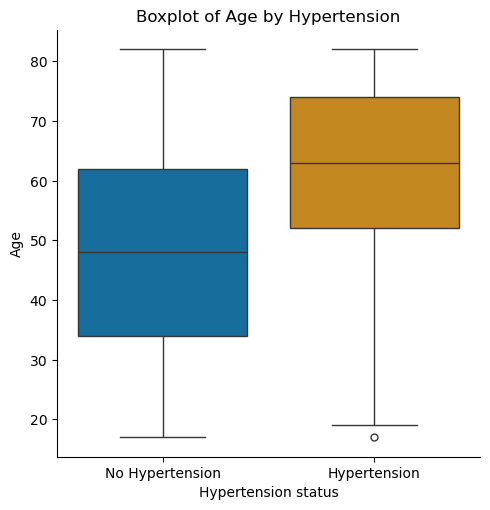

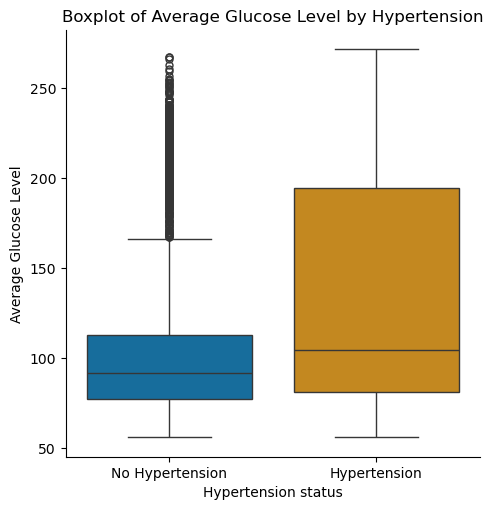

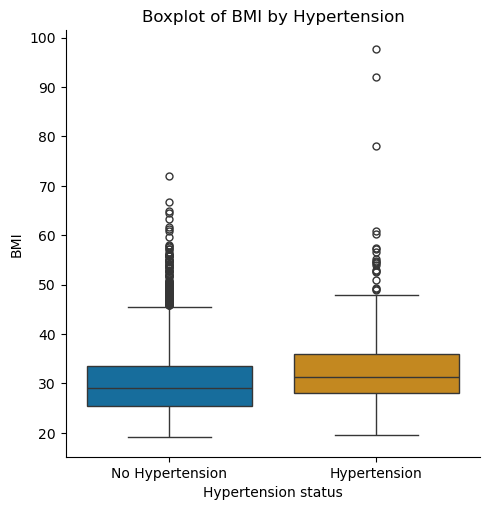

In [448]:
predictors = ['age', 'avg_glucose_level', 'bmi']
target = 'hypertension'

predictor_labels = {
    'age': 'Age',
    'avg_glucose_level': 'Average Glucose Level',
    'bmi': 'BMI'
}

target_label = 'Hypertension'
x_axis_label = 'Hypertension status'
palette = sns.color_palette("colorblind", 2)



for predictor in predictors:
    df_plot = df_small.copy() #create a copy of df_small
    hypertension_labels = {0: 'No Hypertension', 1: 'Hypertension'}

    df_plot['hypertension_label'] = df_plot['hypertension'].map(hypertension_labels)
    
    g = sns.catplot(x= target , y=predictor, data=df_plot, kind="box",
                hue=target, legend=False, palette = palette)
    # Set customized x-axis labels
    g.set_xticklabels(['No Hypertension', 'Hypertension'])  # 0 = No Hypertension, 1 = Hypertension
    plt.title(f'Boxplot of {predictor_labels[predictor]} by {target_label}')
    g.set_axis_labels(x_axis_label, predictor_labels[predictor])

    



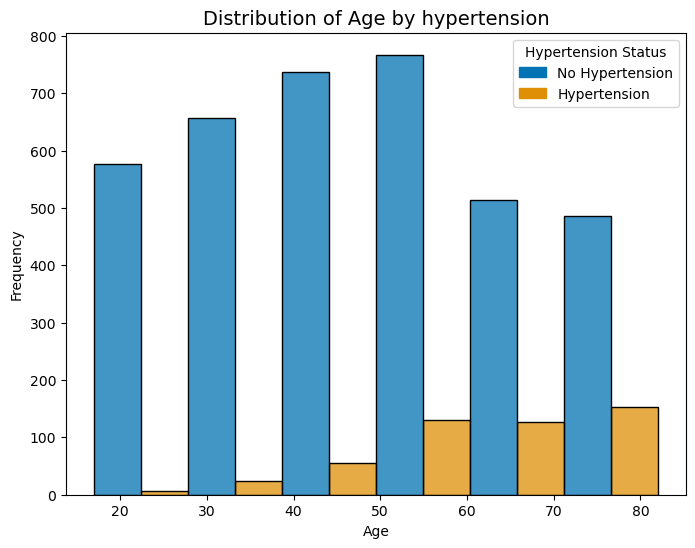

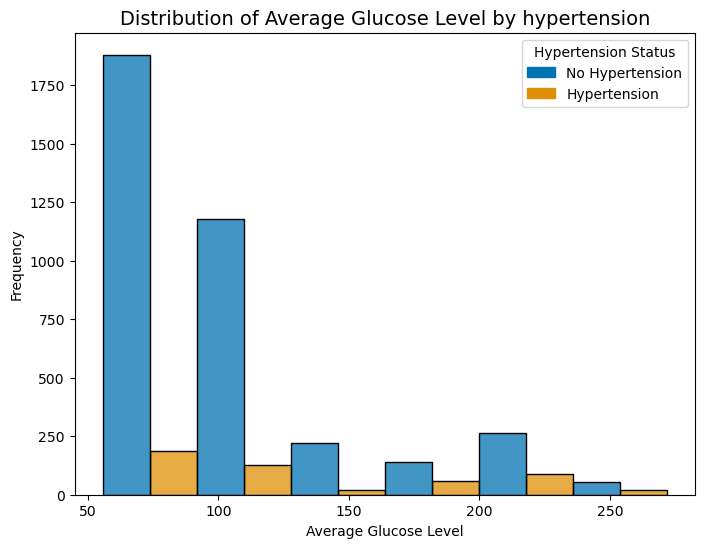

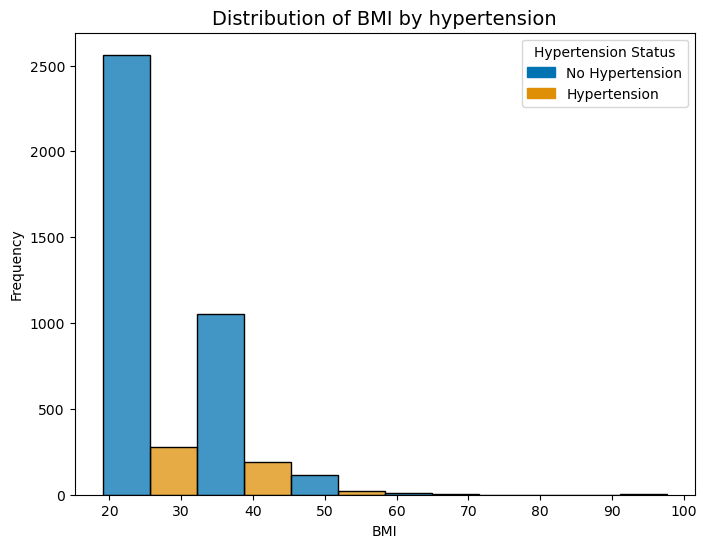

In [449]:

predictors = ['age', 'avg_glucose_level', 'bmi']
target = 'hypertension'

predictor_labels = {
    'age': 'Age',
    'avg_glucose_level': 'Average Glucose Level',
    'bmi': 'BMI'
}

target_label = 'Hypertension'

palette = sns.color_palette("colorblind", 2)
#creating histograms
num_bins = 6
for predictor in predictors:
    df_plot = df_small.copy() #create a copy of df_small
    hypertension_labels = {0: 'No Hypertension', 1: 'Hypertension'} #stroke labels
    df_plot['hypertension_label'] = df_plot['hypertension'].map(stroke_labels)
    plt.figure(figsize=(8, 6))  # Set the figure size

    sns.histplot(data=df_plot, x=predictor, hue=target, kde= False, palette= palette, multiple="dodge", bins = num_bins)
    
    # Set title and axis labels using the custom predictor labels
    plt.title(f'Distribution of {predictor_labels[predictor]} by {target}', fontsize=14)
    plt.xlabel(predictor_labels[predictor])  # Custom x-axis label
    plt.ylabel('Frequency')  # Y-axis label for histograms
    
    # Customize legend
    handles = [plt.Rectangle((0, 0), 1, 1, color= palette[0], label='No Hypertension'),
               plt.Rectangle((0, 0), 1, 1, color= palette[1], label='Hypertension')]
    
    # Add the custom legend
    plt.legend(handles=handles, title='Hypertension Status')
    
    
    # Show the plot
    plt.show()

In [450]:
hypertension_counts = df_small['hypertension'].value_counts()
print (hypertension_counts)

hypertension
0    3737
1     496
Name: count, dtype: int64


In [451]:
#df_small = df[['hypertension', 'age', 'avg_glucose_level', 'bmi' ]]
#predictors = ['age', 'avg_glucose_level', 'bmi']
#target = 'hypertension'
#Shapiro Wilk test
#df_small = df[['stroke', 'age', 'avg_glucose_level', 'bmi' ]]
#predictors = ['age', 'avg_glucose_level', 'bmi']
#target = 'stroke'
hypertension_values = df_small[target].unique()
for predictor in predictors:
    for hypertension_val in hypertension_values:
        #group_data generated for each combination of hypertension status and predictor
        group_data = df_small[df_small[target] == hypertension_val][predictor] 
        stat, p = shapiro(group_data)

        print(f"Shapiro-Wilk test for {predictor} (stroke={hypertension_val}):")
        print(f"  Statistic: {stat}")
        print(f"  p-value: {p}")
    print()





Shapiro-Wilk test for age (stroke=0):
  Statistic: 0.9690970991510096
  p-value: 1.2047928094145992e-27
Shapiro-Wilk test for age (stroke=1):
  Statistic: 0.9535282280544415
  p-value: 2.210002851650892e-11

Shapiro-Wilk test for avg_glucose_level (stroke=0):
  Statistic: 0.7971747143138284
  p-value: 5.196026595606788e-56
Shapiro-Wilk test for avg_glucose_level (stroke=1):
  Statistic: 0.8711711788385341
  p-value: 7.874243529990261e-20

Shapiro-Wilk test for bmi (stroke=0):
  Statistic: 0.9286060529108962
  p-value: 5.4033728477130607e-39
Shapiro-Wilk test for bmi (stroke=1):
  Statistic: 0.8269184685573824
  p-value: 9.316570250871169e-23



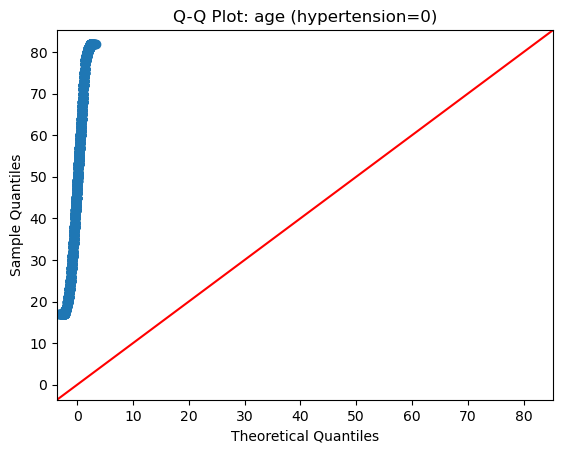

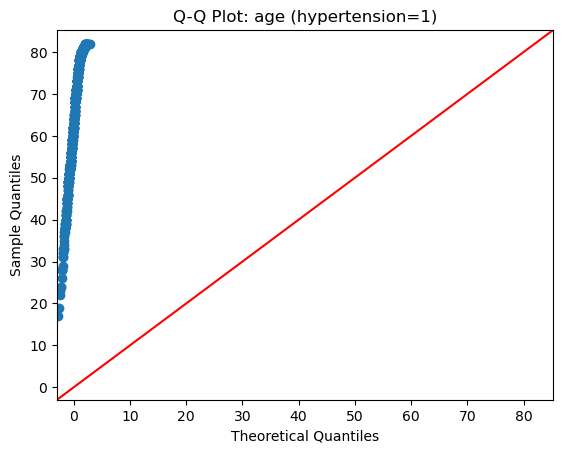

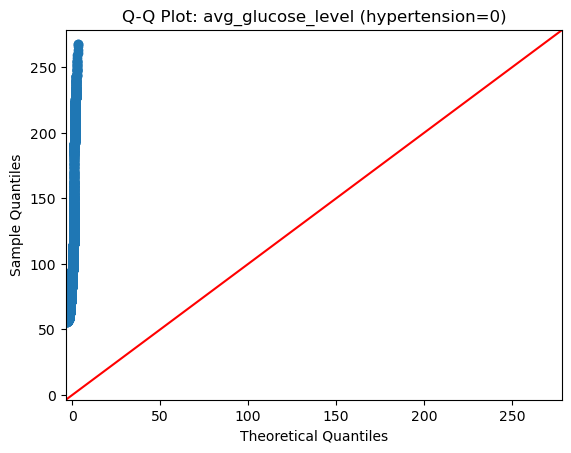

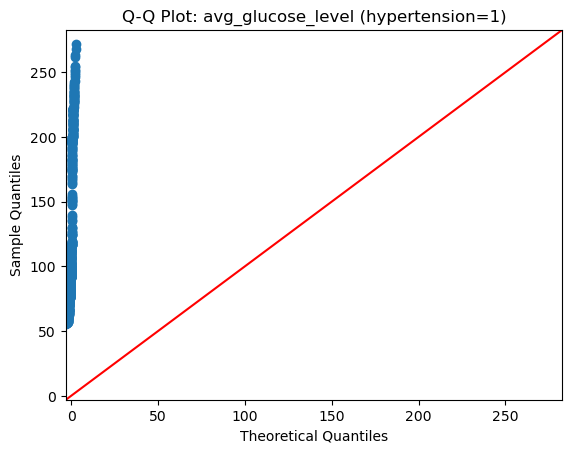

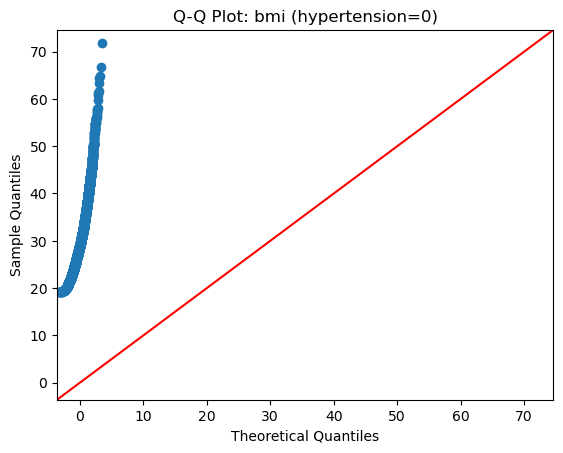

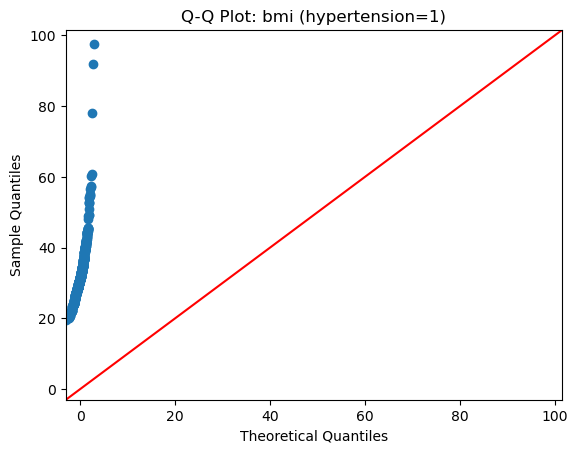

In [452]:
#QQ plots
for predictor in predictors:
    for hypertension_val in hypertension_values:
        group_data = df[df[target] == hypertension_val][predictor]

        # Create Q-Q plot
        sm.qqplot(group_data, line='45')
        plt.title(f'Q-Q Plot: {predictor} (hypertension={hypertension_val})')
        plt.show()



In [453]:
#Mann Whitney U test
for predictor in predictors:
    # Separate the data into two groups based on the 'hypertension' variable
    group_0 = df_small[df_small[target] == 0][predictor]
    group_1 = df_small[df_small[target] == 1][predictor]


    # Perform the Mann-Whitney U test
    stat, p = mannwhitneyu(group_0, group_1, alternative='two-sided')

    # Print the results
    print(f"Mann-Whitney U test for {predictor}:")
    print(f"  U statistic: {stat}")
    print(f"  p-value: {p}")

    # Interpret the p-value
    alpha = 0.05  # Significance level
    if p < alpha:
        print(f"  Result: There is a statistically significant difference in {predictor} between hypertension groups.")
    else:
        print(f"  Result: There is no statistically significant difference in {predictor} between hypertension groups.")

    print()
    print()

Mann-Whitney U test for age:
  U statistic: 511075.5
  p-value: 1.9808043355417353e-59
  Result: There is a statistically significant difference in age between hypertension groups.


Mann-Whitney U test for avg_glucose_level:
  U statistic: 737144.0
  p-value: 1.2143454405547854e-13
  Result: There is a statistically significant difference in avg_glucose_level between hypertension groups.


Mann-Whitney U test for bmi:
  U statistic: 726742.5
  p-value: 5.1969282968467495e-15
  Result: There is a statistically significant difference in bmi between hypertension groups.


